In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
#import statsmodels.formula.api as smf

In [2]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
intraday = pd.read_csv('data/intraDay.csv', dayfirst = True, decimal =',' , index_col=None, parse_dates=[0])

In [4]:
intraday['Date'] = pd.to_datetime(intraday['Date'])
intraday.columns = ['Date', 'Com', 'Fxi', 'Tes']
data = intraday.set_index(['Date']).sort_index(axis=0, ascending=True)

In [5]:
data.head()

,Com,Fxi,Tes
Date,,,
2015-08-28 08:00:00,41.99,3167.0,7.650
2015-08-28 08:05:00,42.15,3174.0,7.641
2015-08-28 08:10:00,42.23,3179.0,7.650
2015-08-28 08:20:00,42.16,3170.5,7.650
2015-08-28 08:25:00,42.25,3159.0,7.635


Calculating simple return of the data frame

In [6]:
nn = data.shift(-1)
rtn = (((nn-data)/nn).shift(1)).fillna(value=0)
rtn.columns = ['Com_rtn', 'Fxi_rtn', 'Tes_rtn']
rtn = rtn.reset_index(['Date'])
rtn.head()

,Date,Com_rtn,Fxi_rtn,Tes_rtn
0,2015-08-28 08:00:00,0.000000,0.000000,0.000000
1,2015-08-28 08:05:00,0.003796,0.002205,-0.001178
2,2015-08-28 08:10:00,0.001894,0.001573,0.001176
3,2015-08-28 08:20:00,-0.001660,-0.002681,0.000000
4,2015-08-28 08:25:00,0.002130,-0.003640,-0.001965


In [7]:
rtn.describe()

,Com_rtn,Fxi_rtn,Tes_rtn
count,6384.000000,6.384000e+03,6384.000000
mean,-0.000024,-5.953671e-07,0.000009
std,0.004692,1.803204e-03,0.001450
min,-0.062321,-1.894230e-02,-0.014608
25%,-0.001798,-7.940289e-04,-0.000622
50%,0.000000,0.000000e+00,0.000000
75%,0.001891,7.861693e-04,0.000634
max,0.057526,2.026699e-02,0.019055


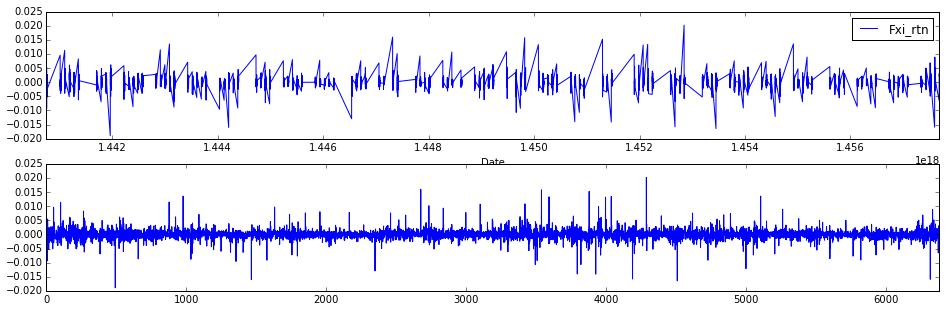

In [11]:
xx =rtn.Date.astype(np.int64) # To convert dates to integers
fig, axs = plt.subplots(2,1)
rtn.plot( x=xx, y='Fxi_rtn', ax=axs[0],figsize=(16, 5))
rtn['Fxi_rtn'].plot( ax=axs[1])

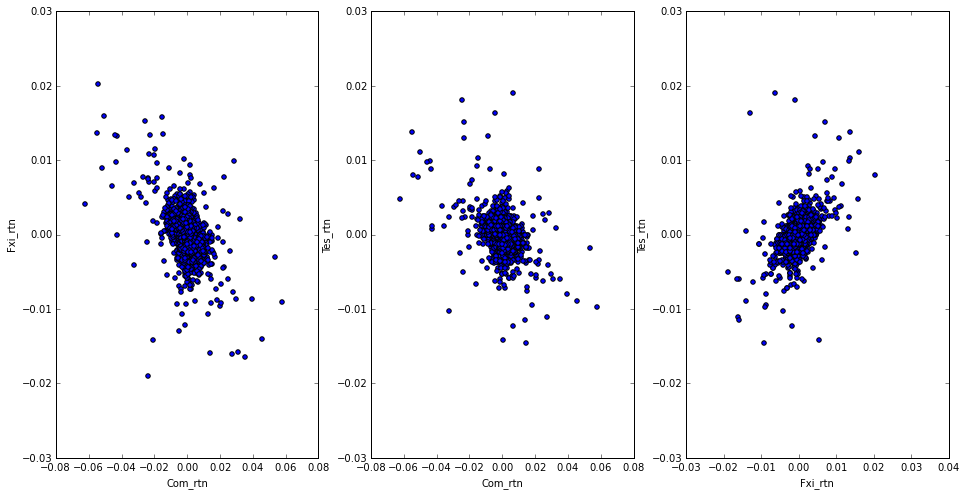

In [12]:
# visualize the relationship between the features and the response using scatterplots
fig, axs = plt.subplots(1, 3)
rtn.plot(kind='scatter', x='Com_rtn', y='Fxi_rtn', ax=axs[0], figsize=(16, 8))
rtn.plot(kind='scatter', x='Com_rtn', y='Tes_rtn', ax=axs[1])
rtn.plot(kind='scatter', x='Fxi_rtn', y='Tes_rtn', ax=axs[2])

Simple return 

In [13]:
# create a fitted model in one line
import statsmodels.formula.api as smf
lm = smf.ols('Tes_rtn ~ Fxi_rtn', data=rtn).fit()
print lm.summary()
# print the coefficients
lm.params

                            OLS Regression Results                            
Dep. Variable:                Tes_rtn   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     1851.
Date:                Sun, 27 Mar 2016   Prob (F-statistic):               0.00
Time:                        21:50:19   Log-Likelihood:                 33482.
No. Observations:                6384   AIC:                        -6.696e+04
Df Residuals:                    6382   BIC:                        -6.695e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   9.284e-06    1.6e-05      0.581      0.5

Intercept    0.000009
Fxi_rtn      0.381256
dtype: float64

In [ ]:
X_new = pd.DataFrame({'Fxi_rtn': [rtn.Fxi_rtn.min(), rtn.Fxi_rtn.max()]})
X_new.head()

In [ ]:
lm.predict(X_new)

In [37]:
xx = pd.DataFrame({'Fxi_rtn': np.linspace(rtn.Fxi_rtn.min(), rtn.Fxi_rtn.max(), 10)})
preds = lm.predict(xx)

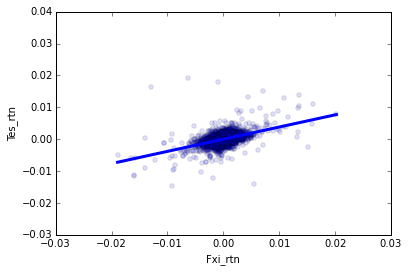

In [38]:
rtn.plot(kind='scatter', x='Fxi_rtn', y='Tes_rtn', alpha = 0.125)
plt.plot(xx,preds, lw=3)

# Confidence intervals

To get the confidence interval you need a bit of a hack...

In [ ]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
sdev, lower, upper = wls_prediction_std(lm, exog=xx, alpha=0.05)

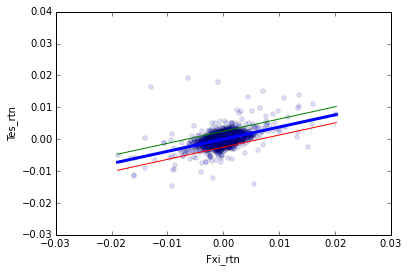

In [39]:
rtn.plot(kind='scatter', x='Fxi_rtn', y='Tes_rtn', alpha = 0.125)
plt.plot(xx,preds, lw=3)
plt.plot(xx,upper, lw=1)
plt.plot(xx,lower, lw=1)

## Alternative

A bit of a hack still....

In [22]:
lm.predict([[1,-0.02], [1, 0.02]], transform=False)

array([-0.00761583,  0.0076344 ])

In [15]:
xx = pd.DataFrame({'Fxi_rtn': np.linspace(rtn.Fxi_rtn.min(), rtn.Fxi_rtn.max(), 10)})
xx = sm.add_constant(xx)  # add constant as we did before

In [16]:
x = xx.Fxi_rtn.values
preds = lm.predict(xx,transform=False)

In [17]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
sdev, lower, upper = wls_prediction_std(lm, exog=xx, alpha=0.05)

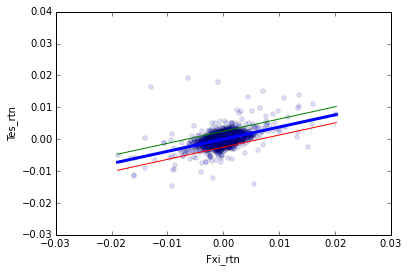

In [18]:
x = xx.Fxi_rtn.values
preds = lm.predict(xx,transform=False)
rtn.plot(kind='scatter', x='Fxi_rtn', y='Tes_rtn', alpha = 0.125)
plt.plot(x,preds, lw=3)
plt.plot(x,upper, lw=1)
plt.plot(x,lower, lw=1)